In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [2]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3', *params, i, 
            gate_round=gate_round, parametrize=True)
        
def two_qubit_layer(circ, gate2='CZ', reverse=False, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    regs = range(0, circ.N - 1)
    if reverse:
        regs = reversed(regs)
    
    for i in regs:
        circ.apply_gate(
            gate2, i, i + 1, gate_round=gate_round)

def ansatz_circuit(n, depth, gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)
    
    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)
        
        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, reverse=r % 2 == 0)
        
    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)
    
    return circ

In [3]:
n = 6
depth = 9
gate2 = 'CZ'

circ = ansatz_circuit(n, depth, gate2=gate2)
circ

<Circuit(n=6, num_gates=105, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

We can extract just the unitary part of the circuit as a tensor network like so:

In [4]:
V = circ.uni

You can see it already has various ``tags`` simultaneously identifying different structures:

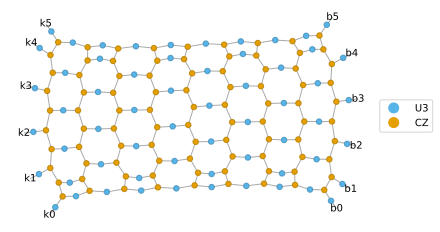

In [5]:
# types of gate
V.draw(color=['U3', gate2], show_inds=True)

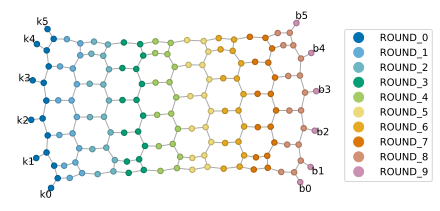

In [6]:
# layers of gates
V.draw(color=[f'ROUND_{i}' for i in range(depth + 1)], show_inds=True)

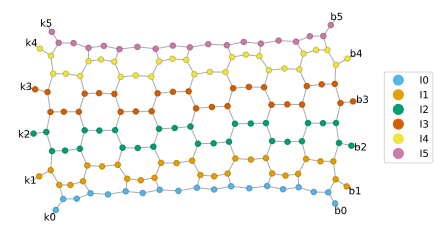

In [7]:
# what register each tensor is 'above'
V.draw(color=[f'I{i}' for i in range(n)], show_inds=True)

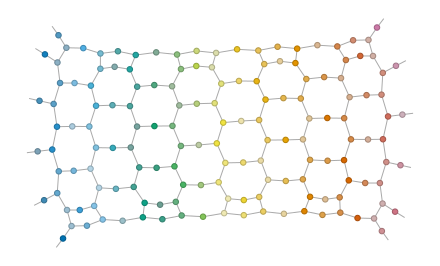

In [8]:
# a unique tag for per gate applied
V.draw(color=[f'GATE_{i}' for i in range(circ.num_gates)], legend=False)

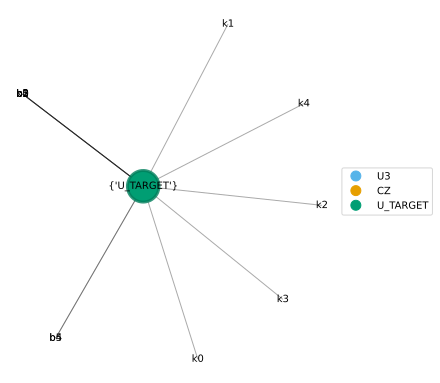

In [9]:
# the hamiltonian
H = qu.ham_ising(n, jz=1.0, bx=0.7, cyclic=False)

# the propagator for the hamiltonian
t = 2
U_dense = qu.expm(-1j * t * H)

# 'tensorized' version of the unitary propagator
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * n)),
    inds=[f'k{i}' for i in range(n)] + [f'b{i}' for i in range(n)],
    tags={'U_TARGET'}
)
U.draw(color=['U3', gate2, 'U_TARGET'])

The core object describing how similar two unitaries are is: $\mathrm{Tr}(V^{\dagger}U)$, which we can naturally visualize at a tensor network:

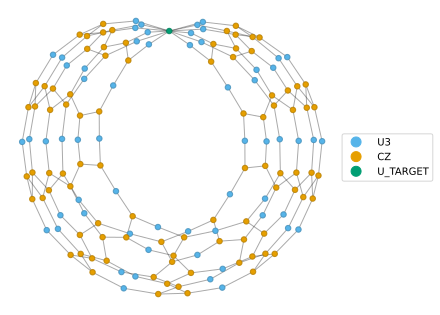

In [10]:
(V.H & U).draw(color=['U3', gate2, 'U_TARGET'])

For our loss function we'll normalize this and negate it (since the optimizer *minimizes*).

In [11]:
def loss(V, U):
    return 1 - abs((V.H & U).contract(all, optimize='auto-hq')) / 2**n

# check our current unitary 'infidelity':
loss(V, U)

0.9888100674294922

In [12]:
# use the autograd/jax based optimizer

tnopt = qtn.TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U},  # supply U to the loss function as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',     # the optimization algorithm
)

In [13]:
# allow 10 hops with 500 steps in each 'basin'
V_opt = tnopt.optimize_basinhopping(n=500, nhop=10)

0.004380524158477783 [best: 0.004311561584472656] :  34%|███▍      | 1720/5000 [00:42<01:21, 40.44it/s] 


The optimized tensor network still contains ``PTensor`` instances but now with optimized parameters. 
For example, here's the tensor of the ``U3`` gate acting on qubit-2 in round-4:

In [14]:
V_opt['U3', 'I2', 'ROUND_4']

PTensor(shape=(2, 2), inds=('_58cffaAAADv', '_58cffaAAADb'), tags=oset(['U3', 'GATE_46', 'ROUND_4', 'I2']))

We can see the parameters have been updated by the training:

In [15]:
# the initial values
V['U3', 'ROUND_4', 'I2'].params

array([0.53624443, 0.37085265, 0.13139528])

In [16]:
# the optimized values
V_opt['U3', 'ROUND_4', 'I2'].params

array([ 0.00073688, -0.26843335, -0.24398612])

We can see what gate these parameters would generate:

In [17]:
qu.U_gate(*V_opt['U3', 'ROUND_4', 'I2'].params)

[[ 9.999999e-01-0.000000e+00j -3.575260e-04+8.900456e-05j]
 [ 3.552435e-04-9.771761e-05j  8.715608e-01-4.902874e-01j]]

A final sanity check we can perform is to try evolving a random state with the target unitary and trained circuit and check the fidelity between the resulting states.

First we turn the tensor network version of $V$ into a dense matrix:

In [18]:
V_opt_dense = V_opt.to_dense([f'k{i}' for i in range(n)], [f'b{i}' for i in range(n)])

Next we create a random initial state, and evolve it with the 

In [19]:
psi0 = qu.rand_ket(2**n)

# this is the exact state we want
psif_exact = U_dense @ psi0

# this is the state our circuit will produce if fed `psi0`
psif_apprx = V_opt_dense @ psi0

The (in)fidelity should broadly match our training loss:

In [20]:
f"Fidelity: {100 * qu.fidelity(psif_apprx, psif_exact):.2f} %"

'Fidelity: 99.60 %'

In [21]:
circ.update_params_from(V_opt)

# the basic gate specification
circ.gates

[('U3', -1.7310705510718456, 0.6169367103757072, 0.3352104540395213, 0),
 ('U3', -1.681015241313202, -0.048673510226722505, 1.5725458637852865, 1),
 ('U3', -0.7074243134666073, 0.5631192998716298, 1.5711382755012164, 2),
 ('U3', 1.3254889133753522, -0.2887850142809405, -1.567509740763241, 3),
 ('U3', 0.7083788639558076, 0.19480896620794058, 1.5830112047363978, 4),
 ('U3', -0.8779819955506539, 1.5181166176740049, -0.2625500798087637, 5),
 ('CZ', 4, 5),
 ('CZ', 3, 4),
 ('CZ', 2, 3),
 ('CZ', 1, 2),
 ('CZ', 0, 1),
 ('U3', 0.5188377403270722, -0.1304543481450544, 0.54493347708154, 0),
 ('U3', 1.582732053146717, -0.27500162252397725, 0.0497842633674875, 1),
 ('U3', 0.010161487565870484, 0.06262846070589156, -0.06971422194716563, 2),
 ('U3', -0.22771364191172694, 1.3127472344753626, 0.2941493959026402, 3),
 ('U3', 1.4341095135325634, 0.8156475232223032, -0.20436458424207693, 4),
 ('U3', 1.513919191228715, 0.7674644386902895, 2.4906386205111453, 5),
 ('CZ', 0, 1),
 ('CZ', 1, 2),
 ('CZ', 2, 3),